In [1]:
import folium    # visualize spatial data in an interactive manner

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library based on matplotlib
import geopandas # working with geospatial data in python easier
import missingno as msn
import matplotlib.pyplot as plt

from folium.plugins import HeatMap
from folium import plugins
from collections import namedtuple
from shapely.geometry import Point

import datetime
!pip install basemap
!pip install basemap-data
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML
from matplotlib.ticker import FuncFormatter
from pylab import rcParams
from matplotlib import animation
from matplotlib import cm
import matplotlib as mpl

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.6/864.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.3 MB/s eta 0:00:00


In [2]:
Traffic_path = '/kaggle/input/ph-datasets/Ph_Datasets/Traffic, Investigations _ Other/'
Crash_path = '/kaggle/input/ph-datasets/Ph_Datasets/Crashes/'

df_crash_info = pd.read_csv(Crash_path+'crash_info_general.csv')
df_crash_info = df_crash_info[df_crash_info.columns[1:]]
cond = (df_crash_info['DEC_LAT'].isna())|(df_crash_info['DEC_LONG'].isna())
df_crash_info = df_crash_info.loc[~cond,:]

df_crash_info = df_crash_info.rename(columns={'DEC_LAT':'lat','DEC_LONG':'lng'})

df_flag = pd.read_csv(Crash_path+'crash_info_flag_variables.csv')
df_flag = df_flag.merge(df_crash_info[['CRN','lat','lng','fips','CRASH_MONTH','CRASH_YEAR','DAY_OF_WEEK']],on=['CRN'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (97,98,99) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Time series analysis

<AxesSubplot:>

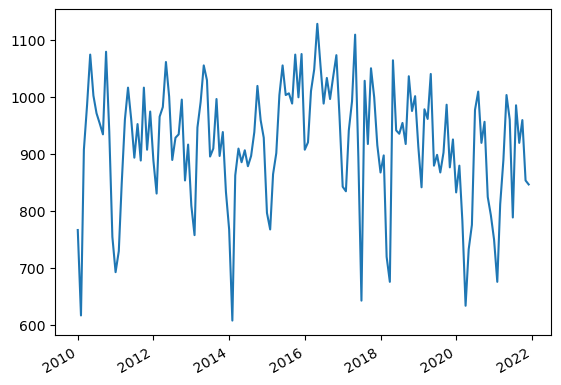

In [3]:
df_time = df_flag.groupby(['CRASH_MONTH','CRASH_YEAR']).CRN.count().reset_index()
dt = []
for i in range(len(df_time)):
    temp = (str(df_time.loc[i,'CRASH_YEAR'])+('-0' if len(str(df_time.loc[i,'CRASH_MONTH']))==1 else "-")+str(df_time.loc[i,'CRASH_MONTH']))
    dt.append(datetime.datetime.strptime(temp,'%Y-%m'))
    
df_time.index = dt
df_time.CRN.plot()

<AxesSubplot:xlabel='CRASH_YEAR'>

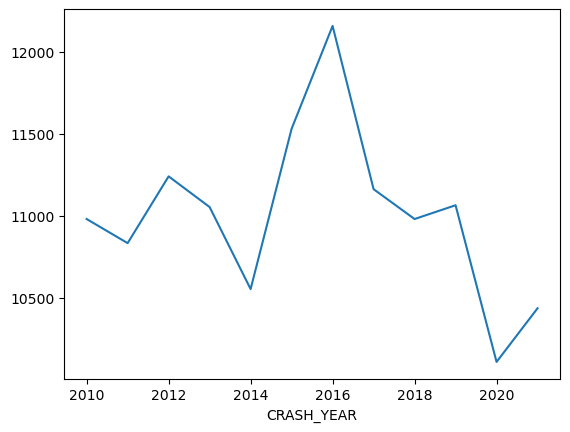

In [4]:
df_time = df_flag.groupby(['CRASH_YEAR']).CRN.count().reset_index()
df_time.index = df_time.CRASH_YEAR
df_time.CRN.plot()

# corr

In [5]:
corr = df_flag[[i for i in df_flag.columns[:110].to_list() if i != 'URBAN']].corr()
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = abs(corr)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# Select columns with correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] >= threshold)]
print(collinear_features)


['DRINKING_DRIVER', 'DRUG_RELATED', 'INJURY_OR_FATAL', 'NON_INTERSECTION', 'PSP_REPORTED', 'SINGLE_VEHICLE', 'STATE_ROAD', 'SUDDEN_DEER', 'TROLLEY']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [6]:
#'DRINKING_DRIVER':ALCOHOL_RELATED IMPAIRED_DRIVER DRUGGED_DRIVER DRUG_RELATED UNDERAGE_DRNK_DRV HIT_PARKED_VEHICLE ILLEGAL_DRUG_RELATED
print(corr['DRINKING_DRIVER'].sort_values(ascending=False).dropna().head(10))
print(corr['DRINKING_DRIVER'].sort_values(ascending=False).dropna().tail(10))

DRINKING_DRIVER         1.000000
ALCOHOL_RELATED         0.947494
IMPAIRED_DRIVER         0.855128
DRUGGED_DRIVER          0.256792
DRUG_RELATED            0.246266
ILLUMINATION_DARK       0.195099
UNDERAGE_DRNK_DRV       0.179902
HIT_PARKED_VEHICLE      0.134740
ILLEGAL_DRUG_RELATED    0.111006
VEHICLE_TOWED           0.110619
Name: DRINKING_DRIVER, dtype: float64
SIGNALIZED_INT        -0.037686
STOP_CONTROLLED_INT   -0.039267
BICYCLE               -0.039681
AGGRESSIVE_DRIVING    -0.048040
INJURY_OR_FATAL       -0.050547
LEFT_TURN             -0.054333
INJURY                -0.056747
ANGLE_CRASH           -0.062730
INTERSECTION          -0.063402
PEDESTRIAN            -0.066152
Name: DRINKING_DRIVER, dtype: float64


In [7]:
#Measuring the loss of crash : INJURY_OR_FATAL INJURY  POSSIBLE_INJURY SUSPECTED_MINOR_INJURY PROPERTY_DAMAGE_ONLY
print(corr['INJURY_OR_FATAL'].sort_values(ascending=False).dropna().head(10))
print(corr['INJURY_OR_FATAL'].sort_values(ascending=False).dropna().tail(10))

INJURY_OR_FATAL              1.000000
INJURY                       0.985463
POSSIBLE_INJURY              0.424163
SUSPECTED_MINOR_INJURY       0.282382
PEDESTRIAN                   0.251342
INTERSECTION                 0.160685
LOCAL_ROAD                   0.127011
BICYCLE                      0.126676
SIGNALIZED_INT               0.126369
FATAL_OR_SUSP_SERIOUS_INJ    0.118332
Name: INJURY_OR_FATAL, dtype: float64
LANE_DEPARTURE         -0.122808
CORE_NETWORK           -0.152686
HIT_PARKED_VEHICLE     -0.153870
SV_RUN_OFF_RD          -0.157593
NON_INTERSECTION       -0.160685
HIT_FIXED_OBJECT       -0.162149
INTERSTATE             -0.179505
PSP_REPORTED           -0.187921
VEHICLE_TOWED          -0.409952
PROPERTY_DAMAGE_ONLY   -0.882047
Name: INJURY_OR_FATAL, dtype: float64


In [8]:
#The wether related crashes may happen on curved road more frequently (SPEEDING related)
print(corr['ICY_ROAD'].sort_values(ascending=False).dropna().head(10))
print(corr['ICY_ROAD'].sort_values(ascending=False).dropna().tail(10))

print(corr['WET_ROAD'].sort_values(ascending=False).dropna().head(10))
print(corr['WET_ROAD'].sort_values(ascending=False).dropna().tail(10))

ICY_ROAD                1.000000
HIT_FIXED_OBJECT        0.058736
LANE_DEPARTURE          0.058576
SV_RUN_OFF_RD           0.056045
CURVED_ROAD             0.041118
SPEEDING_RELATED        0.029798
HIT_POLE                0.029156
PROPERTY_DAMAGE_ONLY    0.025180
HIT_TREE_SHRUB          0.024537
NON_INTERSECTION        0.023805
Name: ICY_ROAD, dtype: float64
AGGRESSIVE_DRIVING   -0.019926
LEFT_TURN            -0.020934
MULTIPLE_VEHICLE     -0.021042
STATE_ROAD           -0.021569
SIGNALIZED_INT       -0.023554
INTERSECTION         -0.023805
INJURY               -0.024093
INJURY_OR_FATAL      -0.025090
ANGLE_CRASH          -0.029315
WET_ROAD             -0.046791
Name: ICY_ROAD, dtype: float64
WET_ROAD             1.000000
SPEEDING_RELATED     0.123940
CURVED_ROAD          0.113783
HIT_FIXED_OBJECT     0.113193
HIT_BARRIER          0.105252
SV_RUN_OFF_RD        0.101232
LANE_DEPARTURE       0.095208
ILLUMINATION_DARK    0.087018
SINGLE_VEHICLE       0.055112
HIT_GDRAIL           0.04740

In [9]:
# possible reasons:interstate;core network;hit barrier;speeding related;state road
# some negative relation:local road;Injury?
print(corr['PSP_REPORTED'].sort_values(ascending=False).dropna().head(10))
print(corr['PSP_REPORTED'].sort_values(ascending=False).dropna().tail(10))

PSP_REPORTED          1.000000
INTERSTATE            0.950825
CORE_NETWORK          0.804456
HIT_BARRIER           0.500644
SPEEDING_RELATED      0.471090
NON_INTERSECTION      0.360160
STATE_ROAD            0.321324
AGGRESSIVE_DRIVING    0.287216
REAR_END              0.254083
LANE_DEPARTURE        0.249040
Name: PSP_REPORTED, dtype: float64
HIT_PARKED_VEHICLE   -0.154944
PEDESTRIAN           -0.169303
LEFT_TURN            -0.179663
INJURY               -0.183431
INJURY_OR_FATAL      -0.187921
ANGLE_CRASH          -0.273535
SIGNALIZED_INT       -0.289876
LOCAL_ROAD_ONLY      -0.310961
INTERSECTION         -0.360160
LOCAL_ROAD           -0.506048
Name: PSP_REPORTED, dtype: float64


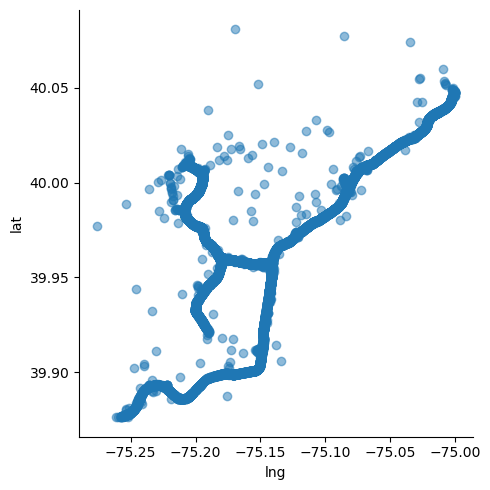

In [10]:
sns.lmplot(x='lng', y='lat', # hue='STREET_NAME', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.PSP_REPORTED==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

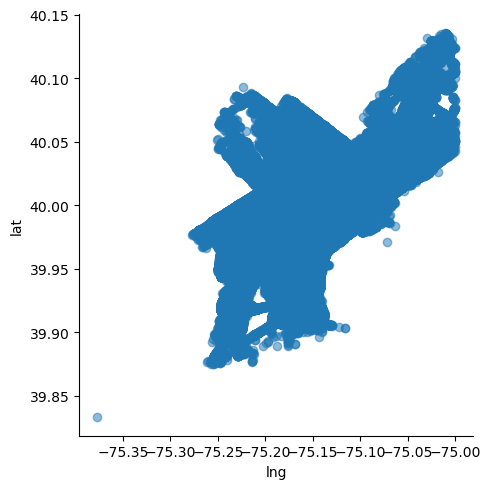

In [11]:
sns.lmplot(x='lng', y='lat', # hue='STREET_NAME', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.PSP_REPORTED!=1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

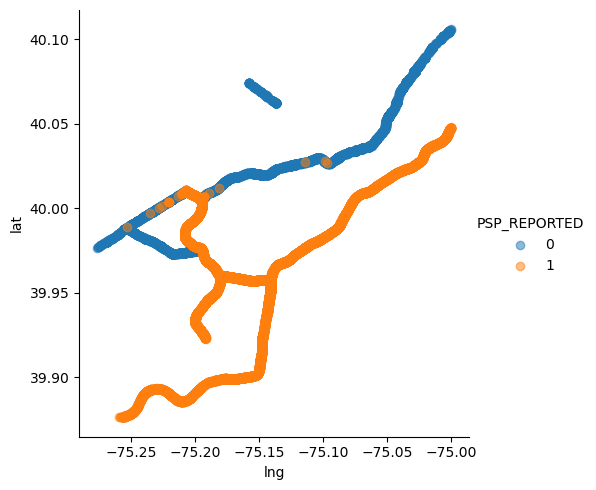

In [12]:
sns.lmplot(x='lng', y='lat',  hue='PSP_REPORTED', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.CORE_NETWORK==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

In [13]:
df_flag[df_flag.columns[:110]].mean().sort_values(ascending=False).iloc[:20]

CRN                     2.015601e+09
URBAN                   1.000000e+00
INJURY_OR_FATAL         7.182402e-01
INJURY                  7.122755e-01
MULTIPLE_VEHICLE        7.012013e-01
VEHICLE_TOWED           6.879168e-01
STATE_ROAD              6.310092e-01
LOCAL_ROAD              5.976277e-01
INTERSECTION            5.129931e-01
AGGRESSIVE_DRIVING      4.909582e-01
NON_INTERSECTION        4.870069e-01
ILLUMINATION_DARK       3.716628e-01
LOCAL_ROAD_ONLY         3.539729e-01
ANGLE_CRASH             3.365251e-01
SIGNALIZED_INT          3.185703e-01
POSSIBLE_INJURY         3.144222e-01
SINGLE_VEHICLE          2.963311e-01
DRIVER_50_64YR          2.580294e-01
PROPERTY_DAMAGE_ONLY    2.338372e-01
REAR_END                2.264267e-01
dtype: float64

In [14]:
#more on state road and reported by psp. related to speeding; no clearance
print(corr['AGGRESSIVE_DRIVING'].sort_values(ascending=False).dropna().head(10))
print(corr['AGGRESSIVE_DRIVING'].sort_values(ascending=False).dropna().tail(10))

AGGRESSIVE_DRIVING    1.000000
SPEEDING_RELATED      0.396771
PSP_REPORTED          0.287216
INTERSTATE            0.277441
CORE_NETWORK          0.272410
RUNNING_RED_LT        0.238065
TAILGATING            0.225974
MULTIPLE_VEHICLE      0.214953
NO_CLEARANCE          0.195808
NHTSA_AGG_DRIVING     0.191016
Name: AGGRESSIVE_DRIVING, dtype: float64
CROSS_MEDIAN         -0.071522
NON_INTERSECTION     -0.082133
HO_OPPDIR_SDSWP      -0.082221
BICYCLE              -0.115962
DISTRACTED           -0.125968
LOCAL_ROAD           -0.126508
LOCAL_ROAD_ONLY      -0.178857
HIT_PARKED_VEHICLE   -0.180093
PEDESTRIAN           -0.197468
SINGLE_VEHICLE       -0.210293
Name: AGGRESSIVE_DRIVING, dtype: float64


In [15]:
print(df_flag['ILLEGAL_DRUG_RELATED'].mean())

print(corr['ILLEGAL_DRUG_RELATED'].sort_values(ascending=False).dropna().head(10))
print(corr['ILLEGAL_DRUG_RELATED'].sort_values(ascending=False).dropna().tail(10))

0.017985148627269906
ILLEGAL_DRUG_RELATED    1.000000
DRUG_RELATED            0.802962
DRUGGED_DRIVER          0.774554
IMPAIRED_DRIVER         0.486846
ALCOHOL_RELATED         0.114744
DRINKING_DRIVER         0.111006
HIT_PARKED_VEHICLE      0.096048
OPIOID_RELATED          0.060116
VEHICLE_TOWED           0.051323
UNBELTED                0.049345
Name: ILLEGAL_DRUG_RELATED, dtype: float64
NO_CLEARANCE          -0.021724
MATURE_DRIVER         -0.022626
STOP_CONTROLLED_INT   -0.023901
DRIVER_50_64YR        -0.024613
SIGNALIZED_INT        -0.026763
UNSIGNALIZED_INT      -0.027338
LEFT_TURN             -0.035920
AGGRESSIVE_DRIVING    -0.039822
ANGLE_CRASH           -0.045996
INTERSECTION          -0.046592
Name: ILLEGAL_DRUG_RELATED, dtype: float64


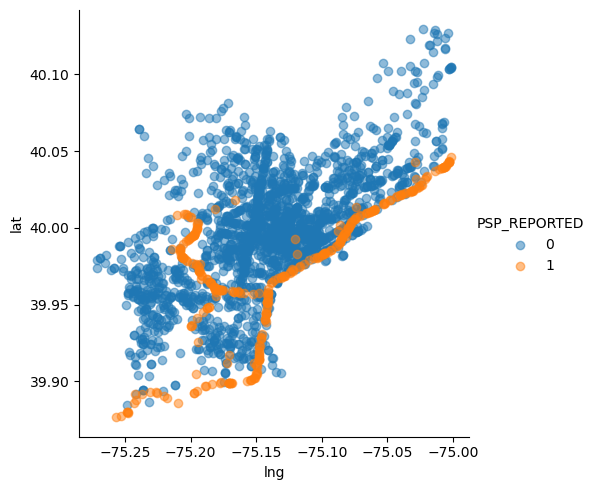

In [16]:
sns.lmplot(x='lng', y='lat',  hue='PSP_REPORTED', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.ILLEGAL_DRUG_RELATED==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

# About what kind of people

In [17]:
df_flag['SCHOOL_ZONE'].mean()

0.007993399389897736

In [18]:
print(corr['SCHOOL_ZONE'].sort_values(ascending=False).dropna().head(10))
print(corr['SCHOOL_ZONE'].sort_values(ascending=False).dropna().tail(10))

SCHOOL_ZONE        1.000000
SCHOOL_BUS         0.078958
PEDESTRIAN         0.058854
SINGLE_VEHICLE     0.035383
LOCAL_ROAD_ONLY    0.028300
LOCAL_ROAD         0.025119
INJURY_OR_FATAL    0.024478
INJURY             0.024192
POSSIBLE_INJURY    0.012078
WORK_ZONE          0.007567
Name: SCHOOL_ZONE, dtype: float64
CURVED_ROAD            -0.015982
REAR_END               -0.019723
PROPERTY_DAMAGE_ONLY   -0.022680
INTERSTATE             -0.027477
PSP_REPORTED           -0.027837
STATE_ROAD             -0.027895
CORE_NETWORK           -0.030165
MULTIPLE_VEHICLE       -0.035000
VEHICLE_TOWED          -0.037507
ILLUMINATION_DARK      -0.037551
Name: SCHOOL_ZONE, dtype: float64


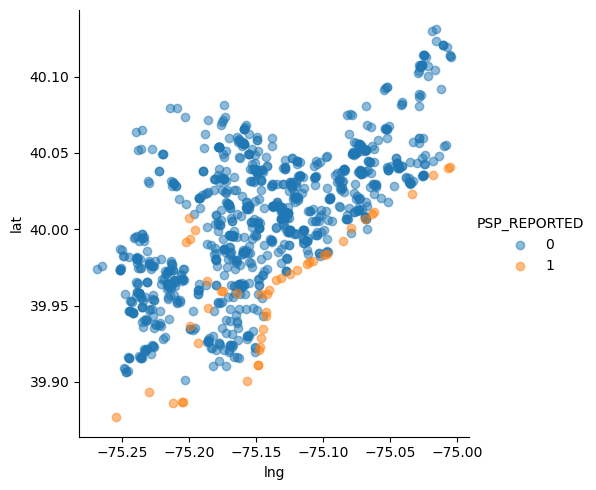

In [19]:
sns.lmplot(x='lng', y='lat',  hue='PSP_REPORTED', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.SCHOOL_ZONE==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

In [20]:
df_flag['YOUNG_DRIVER'].mean()
print(corr['YOUNG_DRIVER'].sort_values(ascending=False).dropna().head(10))
print(corr['YOUNG_DRIVER'].sort_values(ascending=False).dropna().tail(10))

YOUNG_DRIVER          1.000000
DRIVER_20YR           0.590624
DRIVER_19YR           0.529963
DRIVER_18YR           0.436686
DRIVER_17YR           0.311468
DRIVER_16YR           0.149541
UNDERAGE_DRNK_DRV     0.121566
MULTIPLE_VEHICLE      0.090170
VEHICLE_TOWED         0.083993
AGGRESSIVE_DRIVING    0.074043
Name: YOUNG_DRIVER, dtype: float64
IMPAIRED_DRIVER   -0.031533
ALCOHOL_RELATED   -0.031968
DRIVER_75PLUS     -0.033471
COMM_VEHICLE      -0.033623
DRIVER_65_74YR    -0.034399
BICYCLE           -0.045718
MATURE_DRIVER     -0.047375
DRIVER_50_64YR    -0.072009
PEDESTRIAN        -0.088033
SINGLE_VEHICLE    -0.088728
Name: YOUNG_DRIVER, dtype: float64


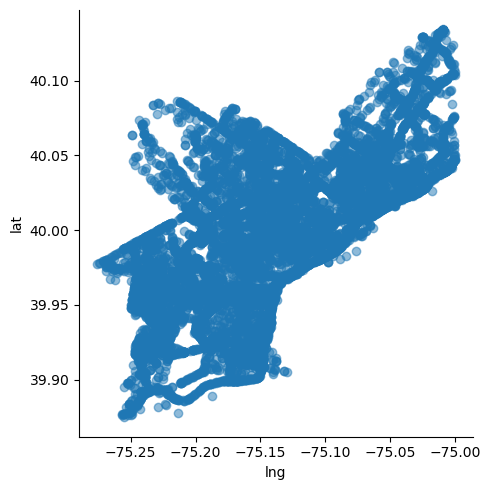

In [21]:
sns.lmplot(x='lng', y='lat',  #hue='YOUNG_DRIVER', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.YOUNG_DRIVER==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

MATURE_DRIVER       1.000000
DRIVER_65_74YR      0.824028
DRIVER_75PLUS       0.543202
MULTIPLE_VEHICLE    0.090164
ANGLE_CRASH         0.067102
INTERSECTION        0.049505
LEFT_TURN           0.041212
INJURY              0.038492
INJURY_OR_FATAL     0.038439
SIGNALIZED_INT      0.038185
Name: MATURE_DRIVER, dtype: float64
SPEEDING_RELATED    -0.041431
YOUNG_DRIVER        -0.047375
LANE_DEPARTURE      -0.049028
NON_INTERSECTION    -0.049505
HIT_BARRIER         -0.050749
DRIVER_50_64YR      -0.061274
HIT_FIXED_OBJECT    -0.073524
SV_RUN_OFF_RD       -0.077993
SINGLE_VEHICLE      -0.088559
ILLUMINATION_DARK   -0.112023
Name: MATURE_DRIVER, dtype: float64


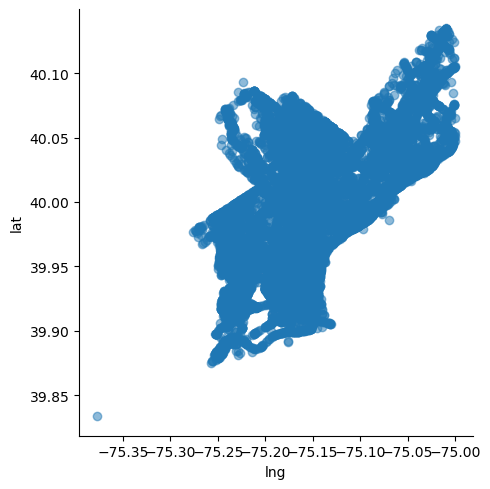

In [22]:
df_flag['MATURE_DRIVER'].mean()
print(corr['MATURE_DRIVER'].sort_values(ascending=False).dropna().head(10))
print(corr['MATURE_DRIVER'].sort_values(ascending=False).dropna().tail(10))

sns.lmplot(x='lng', y='lat',  #hue='YOUNG_DRIVER', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.MATURE_DRIVER==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

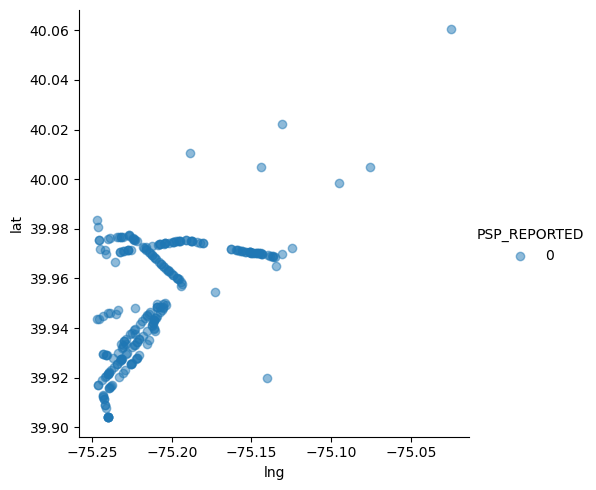

In [23]:
sns.lmplot(x='lng', y='lat',  hue='PSP_REPORTED', 
           data=df_flag[(df_flag.lat>39.8)&(df_flag.lng<-75.0)&
                        (df_flag.TRAIN_TROLLEY==1)],
           fit_reg=False, scatter_kws={'alpha':0.5})

In [24]:
df_where = df_flag[['CRN','lat','lng','PSP_REPORTED','CORE_NETWORK','INTERSTATE','SCHOOL_ZONE','WORK_ZONE','TRAIN_TROLLEY']]
df_age = df_flag[['CRN','lat','lng','YOUNG_DRIVER','MATURE_DRIVER']]
df_reason = df_flag[['CRN','lat','lng','AGGRESSIVE_DRIVING','DRINKING_DRIVER','DRUGGED_DRIVER']]

In [25]:
df_where.to_csv('where.csv',index=False)
df_age.to_csv('age.csv',index=False)
df_reason.to_csv('reason.csv',index=False)